# WF-samples start here

In [36]:
import pandas as pd
import matplotlib.pyplot as plt
import os
import xlrd
import numpy as np
import matplotlib.ticker as mtick

def group(list):
    grouped=[]
    nonpolar=['G','A','V','L','I','P','F','W','M']
    polar=['S','T','C','Y','N','Q']
    basic=['K','R','H']
    acidic=['D','E']
    for item in list:
        new_item=''
        for letter in item:
            if letter in nonpolar:
                new_item+='N'
            if letter in polar:
                new_item+='P'
            if letter in basic:
                new_item+='B'
            if letter in acidic:
                new_item+='A'
        grouped.append(new_item)
    return grouped

def get_letter_frequency(list):
    letters={
        'A':0,
        'G':0,
        'V':0,
        'L':0,
        'I':0,
        'P':0,
        'F':0,
        'W':0,
        'M':0,
        'S':0,
        'T':0,
        'C':0,
        'Y':0,
        'N':0,
        'Q':0,
        'K':0,
        'R':0,
        'H':0,
        'D':0,
        'E':0
    }
    for word in list:
        for letter in word:
            letters[letter] +=1
    return letters

Normal_aminoacids={ #From swissprot
        'A':8.25,
        'G':3.93,
        'V':6.86,
        'L':9.65,
        'I':5.92,
        'P':4.73,
        'F':3.68,
        'W':1.09,
        'M':2.41,
        'S':6.63,
        'T':5.35,
        'C':1.38,
        'Y':2.92,
        'N':4.06,
        'Q':3.93,
        'K':5.81,
        'R':5.53,
        'H':2.27,
        'D':5.46,
        'E':6.72
    }

'C:\\Users\\erikh\\OneDrive\\Dokument\\GitHub\\peptidomic_py'

In [84]:

mapp='WF'
files = os.listdir(mapp)
# gets all xlsx files in cwd
files_xlsx = [f for f in files if f[-4:] == 'xlsx']
df = pd.DataFrame()
for_stdev=[]
total_number_of_peptides=0
number_of_files=0
for file in files_xlsx:
    number_of_files+=1
    data = pd.read_excel(mapp+ '/' +file, 'peptide')
    total_number_of_peptides+=len(data.index)
    data = data.loc[(data['#Feature'] >= 4)] # sorts out if feature<4
    print("Number of total (including modified) peptides in "+file+" "+str(len(data.index)))
    for_stdev.append(len(data.index))
    data['Peptide']=data['Peptide'].str.replace('[^a-zA-Z]','')
    data['count']=1
    data = data.groupby(['Peptide','Accession'], as_index=False).sum()
    data['Mass']=data['Mass']/data['count']
    data['Length']=data['Length']/data['count']
    data['RT']=data['RT']/data['count']
    print("Number of un-modified peptides in "+file+" "+str(len(data.index)))
    df = df.append(data)  # appends all data


df['count'] = 1
df = df.groupby(['Peptide','Accession']).sum()
df.reset_index(['Peptide'], inplace=True)
df['N-cut']=df['Peptide'].apply(lambda x: x[0:4])
df['C-cut']=df['Peptide'].apply(lambda x: x[-4::1])
df['First aa']=df['Peptide'].apply(lambda x: x[0:1])
df['Last aa']=df['Peptide'].apply(lambda x: x[-1::1])
df['Spectral count']=df['#Feature']
df['Spectral count WF1']=df['#Feature WF1']
df['Spectral count WF2']=df['#Feature WF2']
df['Spectral count WF3']=df['#Feature WF 3']
df['Spectral count WF4']=df['#Feature WF4']
df['Spectral count WF5']=df['#Feature WF5']
df = df[['Peptide', 'Mass', 'Length', 'RT', 'Spectral count', 'Spectral count WF1','Spectral count WF2', 'Spectral count WF3', 'Spectral count WF4','Spectral count WF5','count', 'N-cut', 'C-cut','First aa','Last aa']]
df['Mass']=df['Mass']/df['count']
df['Length']=df['Length']/df['count']
df['RT']=df['RT']/df['count']
df = df.sort_values(['Spectral count','Accession','count'], ascending=False)

aminoacids= get_letter_frequency(df['Peptide']*df['count'])
N_aminoacids=get_letter_frequency(df['N-cut']*df['count'])
C_aminoacids=get_letter_frequency(df['C-cut']*df['count'])
First_aa=get_letter_frequency(df['First aa']*df['count'])
Last_aa=get_letter_frequency(df['Last aa']*df['count'])


print("Standard deviation: "+ str(np.std(for_stdev)))
print("Average length: "+str(df['Length'].mean()))
print("Average mass: "+str(df['Mass'].mean()))
print('total number of peptides: '+str(total_number_of_peptides))
print("Number of peptides with feature>=4: "+str(len(df.index))+", in percent: "+str(100*(len(df.index))/(total_number_of_peptides))+" %")
df[0:30]

Number of total (including modified) peptides in peptide _WF1.xlsx 833
Number of un-modified peptides in peptide _WF1.xlsx 766
Number of total (including modified) peptides in peptide_WF2.xlsx 960
Number of un-modified peptides in peptide_WF2.xlsx 884
Number of total (including modified) peptides in peptide_WF3.xlsx 925
Number of un-modified peptides in peptide_WF3.xlsx 865
Number of total (including modified) peptides in peptide_WF4.xlsx 589
Number of un-modified peptides in peptide_WF4.xlsx 543
Number of total (including modified) peptides in peptide_WF5.xlsx 870
Number of un-modified peptides in peptide_WF5.xlsx 802
Standard deviation: 130.74341283598193
Average length: 12.612202688728026
Average mass: 1399.0946740277777
total number of peptides: 16657
Number of peptides with feature>=4: 1934, in percent: 11.610734225850994 %


,Peptide,Mass,Length,RT,Spectral count,Spectral count WF1,Spectral count WF2,Spectral count WF3,Spectral count WF4,Spectral count WF5,count,N-cut,C-cut,First aa,Last aa
Accession,,,,,,,,,,,,,,,
sp|Q04206|TF65_HUMAN,PSLQAPVR,866.497400,8.0,14.880000,160,23.0,8.0,38.0,52.0,38.0,5,PSLQ,APVR,P,R
sp|P01009|A1AT_HUMAN,AVLTIDEKGTEAAGAMF,1738.844700,17.0,67.552500,103,6.0,0.0,47.0,12.0,38.0,4,AVLT,GAMF,A,F
sp|P04406|G3P_HUMAN,AVGKVIPELNGKLTGMAF,1860.608200,18.0,73.212000,65,12.0,12.0,16.0,18.0,7.0,5,AVGK,GMAF,A,F
sp|Q14624|ITIH4_HUMAN,NFRPGVL,802.040100,7.0,41.191000,58,13.0,13.0,14.0,6.0,12.0,5,NFRP,PGVL,N,L
sp|P06727|APOA4_HUMAN,NHQLEGLTF,1058.273700,9.0,66.895667,58,9.0,11.0,10.0,15.0,13.0,5,NHQL,GLTF,N,F
sp|Q14624|ITIH4_HUMAN,SRQLGLPGPPDVPDHA,1655.236300,16.0,52.350000,56,12.0,14.0,11.0,8.0,11.0,5,SRQL,PDHA,S,A
sp|P02671|FIBA_HUMAN,MELERPGGNEIT,1361.121300,12.0,20.979000,55,11.0,10.0,12.0,12.0,10.0,5,MELE,NEIT,M,T
sp|P02652|APOA2_HUMAN,NFLSYFVELGTQPATQ,1813.888700,16.0,117.848000,55,11.0,14.0,9.0,9.0,12.0,5,NFLS,PATQ,N,Q
sp|P02655|APOC2_HUMAN,GIFTDQVLSVLKGEE,1634.151400,15.0,111.304000,53,14.0,13.0,7.0,6.0,13.0,5,GIFT,KGEE,G,E


### Aminoacid profile

Text(0.5, 1.0, 'Last aminoacid')

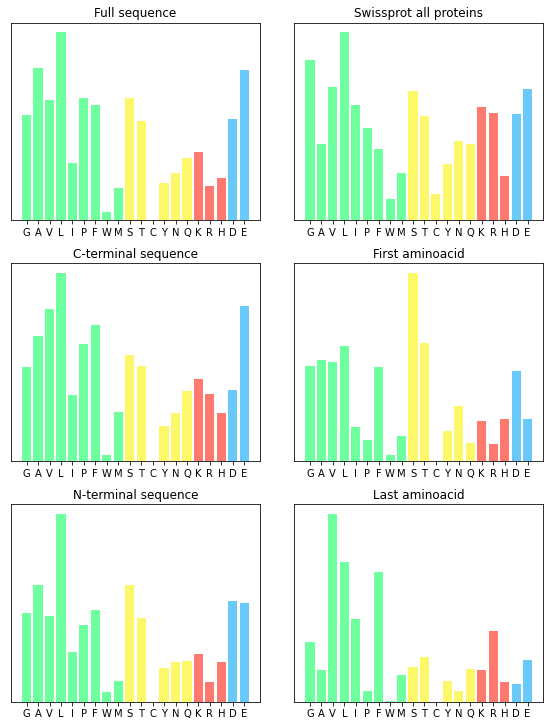

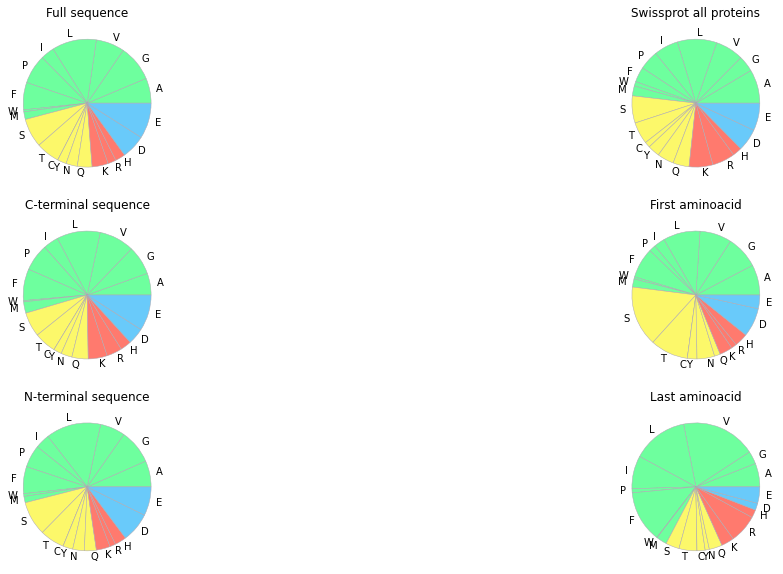

In [4]:

color=['#6eff9e', '#6eff9e','#6eff9e','#6eff9e','#6eff9e','#6eff9e','#6eff9e','#6eff9e','#6eff9e','#fcf86a','#fcf86a','#fcf86a','#fcf86a','#fcf86a','#fcf86a','#ff7a6e','#ff7a6e','#ff7a6e','#69cafa','#69cafa','#69cafa']


fig, ax1 = plt.subplots(3,2,figsize=(8,10))
ax1[0,0].bar(range(len(aminoacids)), list(aminoacids.values()), align='center', color=color)
ax1[2,0].bar(range(len(N_aminoacids)), list(N_aminoacids.values()), align='center', color=color)
ax1[1,0].bar(range(len(C_aminoacids)), list(C_aminoacids.values()), align='center', color=color)
ax1[1,1].bar(range(len(First_aa)), list(First_aa.values()), align='center', color=color)
ax1[2,1].bar(range(len(Last_aa)), list(Last_aa.values()), align='center', color=color)
ax1[0,1].bar(range(len(Normal_aminoacids)), list(Normal_aminoacids.values()), align='center', color=color)

ax1[0,0].set_title('Full sequence')
ax1[0,1].set_title('Swissprot all proteins')
ax1[2,0].set_title('N-terminal sequence')
ax1[1,0].set_title('C-terminal sequence')
ax1[1,1].set_title('First aminoacid')
ax1[2,1].set_title('Last aminoacid')

plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=1.0)
plt.setp(ax1, xticks=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19], xticklabels=['G','A','V','L','I','P','F','W','M','S','T','C','Y','N','Q','K','R','H','D','E'], yticks=([]))

fig, ax = plt.subplots(3,2,figsize=(20,10))
wp = { 'linewidth' : 0.5, 'edgecolor' : "#afabb3" } 

ax[0,0].pie(aminoacids.values(),labels = aminoacids.keys(), colors=color, wedgeprops=wp) 
ax[2,0].pie(N_aminoacids.values(),labels =N_aminoacids.keys(), colors=color, wedgeprops=wp) 
ax[1,0].pie(C_aminoacids.values(),labels = C_aminoacids.keys(), colors=color, wedgeprops=wp) 
ax[1,1].pie(First_aa.values(),labels = First_aa.keys(), colors=color, wedgeprops=wp) 
ax[2,1].pie(Last_aa.values(),labels = Last_aa.keys(), colors=color, wedgeprops=wp) 
ax[0,1].pie(Normal_aminoacids.values(),labels = Normal_aminoacids.keys(), colors=color, wedgeprops=wp) 

ax[0,0].set_title('Full sequence')
ax[0,1].set_title('Swissprot all proteins')
ax[2,0].set_title('N-terminal sequence')
ax[1,0].set_title('C-terminal sequence')
ax[1,1].set_title('First aminoacid')
ax[2,1].set_title('Last aminoacid')

## Graph of aminoacid frequency in complete sequences

### How does feature and count correlate in these samples? Are there certain peptides with abnormal feature?

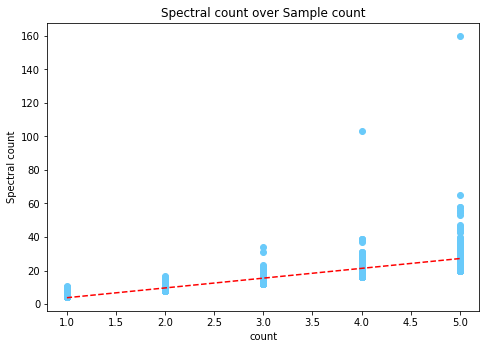

[ 5.83795291 -2.05816869]
0.6841446410359685
1934


In [5]:
fig=plt.figure()
ax=fig.add_axes([0,0,1,1])
ax.scatter(df['count'], df['Spectral count'], color='#69cafa')
z = np.polyfit(df['count'], df['Spectral count'], 1)
p = np.poly1d(z)
plt.plot(df['count'],p(df['count']),"r--")
ax.set_xlabel('count')
ax.set_ylabel('Spectral count')
ax.set_title('Spectral count over Sample count')
plt.show()

correlation_matrix = np.corrcoef(df['count'], df['Spectral count'])
correlation_xy = correlation_matrix[0,1]
r_squared = correlation_xy**2
print(z)
print(r_squared)
print(len(df.index))

In [6]:
df.sort_values(['Spectral count'], ascending=False).head()

,Peptide,Mass,Length,RT,Spectral count,Spectral count WF1,Spectral count WF2,Spectral count WF3,Spectral count WF4,Spectral count WF5,count,N-cut,C-cut,First aa,Last aa
Accession,,,,,,,,,,,,,,,
sp|Q04206|TF65_HUMAN,PSLQAPVR,866.4974,8.0,14.880000,160,23.0,8.0,38.0,52.0,38.0,5,PSLQ,APVR,P,R
sp|P01009|A1AT_HUMAN,AVLTIDEKGTEAAGAMF,1738.8447,17.0,67.552500,103,6.0,0.0,47.0,12.0,38.0,4,AVLT,GAMF,A,F
sp|P04406|G3P_HUMAN,AVGKVIPELNGKLTGMAF,1860.6082,18.0,73.212000,65,12.0,12.0,16.0,18.0,7.0,5,AVGK,GMAF,A,F
sp|Q14624|ITIH4_HUMAN,NFRPGVL,802.0401,7.0,41.191000,58,13.0,13.0,14.0,6.0,12.0,5,NFRP,PGVL,N,L
sp|P06727|APOA4_HUMAN,NHQLEGLTF,1058.2737,9.0,66.895667,58,9.0,11.0,10.0,15.0,13.0,5,NHQL,GLTF,N,F


### What are the most frequent N,C-terminals and what is their sequence? How often are they found? Are there outliers? OOPS: Mass length etc are fucked

In [7]:
#Here we sort on the C and N-cut

df_N=df.groupby(['Accession', 'N-cut']).sum()
df_N=df_N.sort_values(['count'], ascending=False)
df_N=df_N.drop(['Mass','Length','RT'], axis=1)
#sorted by accession and then C-cut. KGEE is found 48 times in APOC2
df_C=df.groupby(['Accession', 'C-cut']).sum()
df_C=df_C.drop(['Mass','Length','RT'], axis=1)
df_C=df_C.sort_values(['Spectral count'], ascending=False)

df_C.head()


,,Spectral count,Spectral count WF1,Spectral count WF2,Spectral count WF3,Spectral count WF4,Spectral count WF5,count
Accession,C-cut,,,,,,,
sp|P02655|APOC2_HUMAN,KGEE,277,58.0,56.0,60.0,41.0,62.0,45
sp|P69905|HBA_HUMAN,RMFL,264,56.0,48.0,79.0,24.0,57.0,38
sp|P02671|FIBA_HUMAN,GEFV,226,48.0,46.0,57.0,42.0,33.0,47
sp|Q14624|ITIH4_HUMAN,PDHA,205,50.0,59.0,44.0,25.0,27.0,28
sp|P01009|A1AT_HUMAN,GAMF,202,23.0,4.0,72.0,25.0,78.0,22


1157
1024


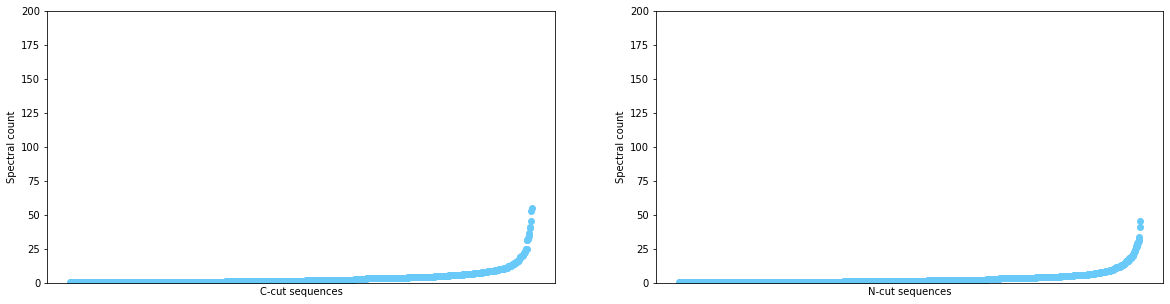

In [8]:
#These graphs show how the variation of N/C-GROUPS vary in a sample. As seen, it's not linear but exponential.

df_N.reset_index(['Accession'], inplace=True)
df_C.reset_index(['Accession'], inplace=True)
df_C=df.groupby(['C-cut']).sum()
df_N=df.groupby(['N-cut']).sum()
df_N=df_N.sort_values('Spectral count')
df_C=df_C.sort_values('Spectral count')
fig, ax = plt.subplots(1,2,figsize=(20,5))
ax[1].set_xticklabels([])
ax[0].set_xticklabels([])
ax[0].set_xlabel('C-cut sequences')
ax[1].set_xlabel('N-cut sequences')
ax[0].set_ylabel('Spectral count')
ax[1].set_ylabel('Spectral count')
plt.setp(ax, ylim=(0,200))
ax[1].scatter(df_N.index, df_N['Spectral count']/number_of_files, color='#69cafa') #row=0, col=0, kanske mer relevant att kolla mot feature? Annars tittar vi mot "variation"
ax[0].scatter(df_C.index, df_C['Spectral count']/number_of_files, color='#69cafa') #row=1, col=0
ax[0].tick_params(
    axis='x',          
    which='both',      
    bottom=False,      
    top=False,         
    labelbottom=False)
ax[1].tick_params(
    axis='x',          
    which='both',      
    bottom=False,      
    top=False,         
    labelbottom=False)
print(len(df_N.index))
print(len(df_C.index))

### What are the most frequent groups of AA at the N,C-terminal? Are there any favou#ff7a6e combinations?

In [9]:
#This adds the N/C-grouped column when df is grouped mainly on protein, although the index is removed, and then on N/C-cutsite which is kept. 
#It is therefore still indirectly sorted on protein. There is no "respective peptide" available, although this can be easily added by sorting on Peptide aswell.

#might be an easier way to code

df_N= df.groupby(['Accession','N-cut']).sum() #groups original DataFrame by protein and n-cut. Makes protein and cut indexes
df_N = df_N.sort_values(['count','Spectral count'], ascending=False) #sorts these values by count and feature
df_N.reset_index(['Accession'], inplace=True) #removes protein from index, only cut left
df_N['N-grouped']=group(df_N.index) #creates column of N-grouped based on index, cut
df_N=df_N.drop(['Mass', 'Length','RT'], axis=1)
df_N=df_N.groupby(['N-grouped']).sum() #groups by N-grouped instead

df_N=df_N.sort_values(['count','Spectral count'], ascending=False) #sorts the grouped index on count and feature

df_C = df.groupby(['Accession','C-cut']).sum() 
df_C = df_C.sort_values(['count','Spectral count'], ascending=False)
df_C.reset_index(['Accession'], inplace=True)
df_C['C-grouped']=group(df_C.index)
df_C=df_C.drop(['Mass', 'Length','RT'], axis=1)
df_C=df_C.groupby(['C-grouped']).sum()


df_C=df_C.sort_values(['count','Spectral count'], ascending=False)
df_C.head()

,Spectral count,Spectral count WF1,Spectral count WF2,Spectral count WF3,Spectral count WF4,Spectral count WF5,count
C-grouped,,,,,,,
NNNN,1255,254.0,223.0,282.0,164.0,330.0,241
NPNN,947,217.0,292.0,163.0,125.0,150.0,211
NANN,683,141.0,160.0,157.0,117.0,108.0,152
PNNN,584,102.0,146.0,99.0,83.0,154.0,138
NNPN,587,116.0,140.0,149.0,89.0,93.0,126


165
162


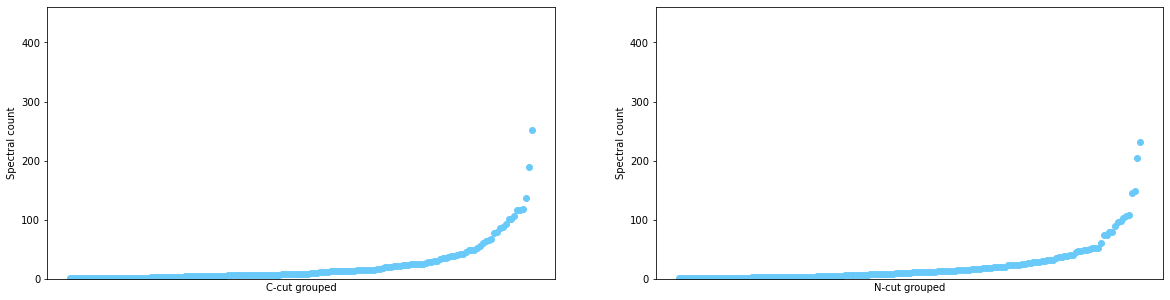

In [10]:
#These graphs show how the variation of N/C-GROUPS vary in a sample. As seen, it's not linear but exponential.
#These graphs show how the variation of N/C-GROUPS vary in a sample. As seen, it's not linear but exponential.
df_N=df_N.sort_values(['Spectral count'], ascending=True)
df_C=df_C.sort_values(['Spectral count'], ascending=True)
fig, ax = plt.subplots(1,2, figsize=(20,5))
plt.setp(ax, ylim=(0,460))
ax[1].set_xticklabels([])
ax[0].set_xticklabels([])
ax[0].set_xlabel('C-cut grouped')
ax[1].set_xlabel('N-cut grouped')
ax[0].set_ylabel('Spectral count')
ax[1].set_ylabel('Spectral count')
ax[1].scatter(df_N.index, df_N['Spectral count']/number_of_files, color='#69cafa') #row=0, col=0
ax[0].scatter(df_C.index, df_C['Spectral count']/number_of_files, color='#69cafa') #row=1, col=0
ax[0].tick_params(
    axis='x',          
    which='both',      
    bottom=False,      
    top=False,         
    labelbottom=False)
ax[1].tick_params(
    axis='x',          
    which='both',      
    bottom=False,      
    top=False,         
    labelbottom=False)
print(len(df_N.index))
print(len(df_C.index))

# Infected samples start here

In [86]:
mapp='peptide_sample_inf'
files = os.listdir(mapp)
# gets all xlsx files in cwd
files_xlsx = [f for f in files if f[-4:] == 'xlsx']
df = pd.DataFrame()
for_stdev=[]
total_number_of_peptides=0
number_of_files=0
for file in files_xlsx:
    number_of_files+=1
    data = pd.read_excel(mapp+ '/' +file, 'peptide')
    total_number_of_peptides+=len(data.index)
    print("Number of total (including modified) peptides in "+file+" "+str(len(data.index)))
    for_stdev.append(len(data.index))
    data['Peptide']=data['Peptide'].str.replace('[^a-zA-Z]','')
    data['count']=1
    data = data.groupby(['Peptide','Accession'], as_index=False).sum()
    data['Mass']=data['Mass']/data['count']
    data['Length']=data['Length']/data['count']
    data['RT']=data['RT']/data['count']
    print("Number of un-modified peptides in "+file+" "+str(len(data.index)))
    data = data.loc[(data['#Feature'] >= 4)] # sorts out if feature<4
    df = df.append(data)  # appends all data


df['count'] = 1
df = df.groupby(['Accession','Peptide']).sum()
df.reset_index(['Peptide'], inplace=True)
df['N-cut']=df['Peptide'].apply(lambda x: x[0:4]) #this can be changed to view different amounts of AA
df['C-cut']=df['Peptide'].apply(lambda x: x[-4::1])
df['First aa']=df['Peptide'].apply(lambda x: x[0:1])
df['Last aa']=df['Peptide'].apply(lambda x: x[-1::1])
df['Spectral count']=df['#Feature']
df['Spectral count Sample 31']= df['#Feature Sample 31']
df['Spectral count Sample 34']=df['#Feature Sample 34']
df['Spectral count Sample 39']=df['#Feature Sample 39']
df = df[['Peptide', 'Mass', 'Length', 'RT', 'Spectral count', 'Spectral count Sample 31','Spectral count Sample 34', 'Spectral count Sample 39','count', 'N-cut', 'C-cut', 'First aa', 'Last aa']]
df['Mass']=df['Mass']/df['count']
df['Length']=df['Length']/df['count']
df['RT']=df['RT']/df['count']
df = df.sort_values(['count','Spectral count'], ascending=False)

aminoacids= get_letter_frequency(df['Peptide']*df['count'])
N_aminoacids=get_letter_frequency(df['N-cut']*df['count'])
C_aminoacids=get_letter_frequency(df['C-cut']*df['count'])
First_aa=get_letter_frequency(df['First aa']*df['count'])
Last_aa=get_letter_frequency(df['Last aa']*df['count'])


print("Standard deviation: "+ str(np.std(for_stdev)))
print("Total amount of peptides "+str(total_number_of_peptides))
print("Average length: "+str(df['Length'].mean()))
print("Average mass: "+str(df['Mass'].mean()))
print("Total number of peptides with feature>=4: "+str(len(df.index)))
print("Number of peptides with feature>=4: "+str(len(df.index))+", in percent: "+str(100*(len(df.index))/(total_number_of_peptides))+" %")
df.head()


Number of total (including modified) peptides in peptide_sample_31.xlsx 5103
Number of un-modified peptides in peptide_sample_31.xlsx 4055
Number of total (including modified) peptides in peptide_sample_34.xlsx 1412
Number of un-modified peptides in peptide_sample_34.xlsx 1218
Number of total (including modified) peptides in peptide_sample_39.xlsx 4929
Number of un-modified peptides in peptide_sample_39.xlsx 3817
Standard deviation: 1700.4262864221887
Total amount of peptides 11444
Average length: 13.731363331094695
Average mass: 1494.5794611588155
Total number of peptides with feature>=4: 1489
Number of peptides with feature>=4: 1489, in percent: 13.011184900384482 %


,Peptide,Mass,Length,RT,Spectral count,Spectral count Sample 31,Spectral count Sample 34,Spectral count Sample 39,count,N-cut,C-cut,First aa,Last aa
Accession,,,,,,,,,,,,,
sp|P68871|HBB_HUMAN:sp|P02042|HBD_HUMAN,AGVANALAHKYH,1251.1440,12.0,86.333333,115,40.0,15.0,60.0,3,AGVA,HKYH,A,H
sp|P68871|HBB_HUMAN:sp|P02042|HBD_HUMAN,GVANALAHKYH,1179.9429,11.0,75.975000,109,42.0,12.0,55.0,3,GVAN,HKYH,G,H
sp|P68871|HBB_HUMAN:sp|P02042|HBD_HUMAN,ANALAHKYH,1023.8530,9.0,59.131667,96,35.0,9.0,52.0,3,ANAL,HKYH,A,H
sp|P68871|HBB_HUMAN,VHLTPEEKSAV,1208.6400,11.0,50.666667,78,28.0,14.0,36.0,3,VHLT,KSAV,V,V
sp|P69905|HBA_HUMAN,STVLTSKYR,1053.5818,9.0,119.810000,77,21.0,15.0,41.0,3,STVL,SKYR,S,R


Text(0.5, 1.0, 'Last aminoacid')

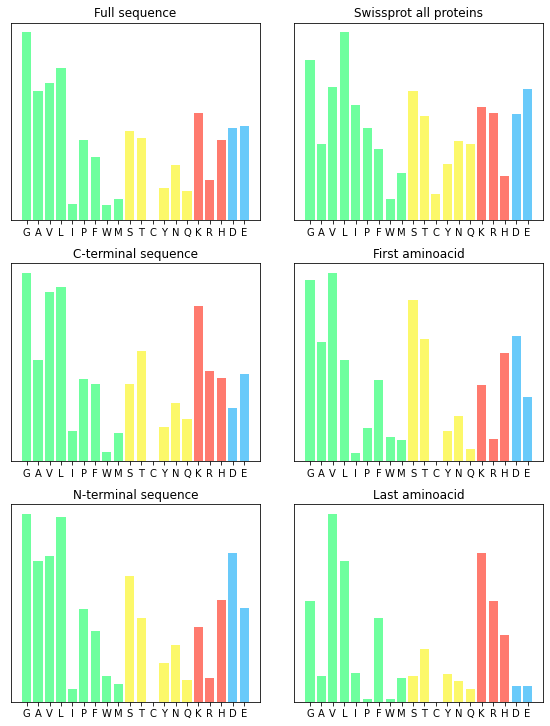

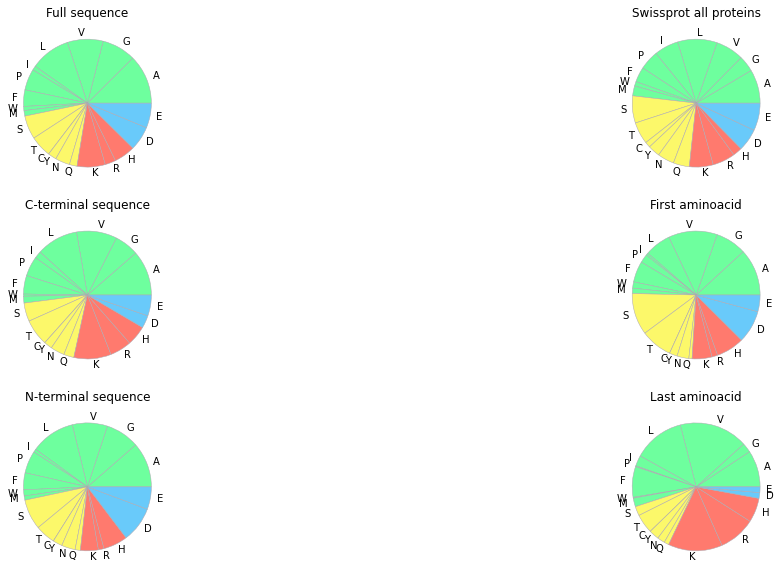

In [12]:

color=['#6eff9e', '#6eff9e','#6eff9e','#6eff9e','#6eff9e','#6eff9e','#6eff9e','#6eff9e','#6eff9e','#fcf86a','#fcf86a','#fcf86a','#fcf86a','#fcf86a','#fcf86a','#ff7a6e','#ff7a6e','#ff7a6e','#69cafa','#69cafa','#69cafa']


fig, ax1 = plt.subplots(3,2,figsize=(8,10))
ax1[0,0].bar(range(len(aminoacids)), list(aminoacids.values()), align='center', color=color)
ax1[2,0].bar(range(len(N_aminoacids)), list(N_aminoacids.values()), align='center', color=color)
ax1[1,0].bar(range(len(C_aminoacids)), list(C_aminoacids.values()), align='center', color=color)
ax1[1,1].bar(range(len(First_aa)), list(First_aa.values()), align='center', color=color)
ax1[2,1].bar(range(len(Last_aa)), list(Last_aa.values()), align='center', color=color)
ax1[0,1].bar(range(len(Normal_aminoacids)), list(Normal_aminoacids.values()), align='center', color=color)

ax1[0,0].set_title('Full sequence')
ax1[0,1].set_title('Swissprot all proteins')
ax1[2,0].set_title('N-terminal sequence')
ax1[1,0].set_title('C-terminal sequence')
ax1[1,1].set_title('First aminoacid')
ax1[2,1].set_title('Last aminoacid')

plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=1.0)
plt.setp(ax1, xticks=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19], xticklabels=['G','A','V','L','I','P','F','W','M','S','T','C','Y','N','Q','K','R','H','D','E'], yticks=([]))

fig, ax = plt.subplots(3,2,figsize=(20,10))
wp = { 'linewidth' : 0.5, 'edgecolor' : "#afabb3" } 

ax[0,0].pie(aminoacids.values(),labels = aminoacids.keys(), colors=color, wedgeprops=wp) 
ax[2,0].pie(N_aminoacids.values(),labels =N_aminoacids.keys(), colors=color, wedgeprops=wp) 
ax[1,0].pie(C_aminoacids.values(),labels = C_aminoacids.keys(), colors=color, wedgeprops=wp) 
ax[1,1].pie(First_aa.values(),labels = First_aa.keys(), colors=color, wedgeprops=wp) 
ax[2,1].pie(Last_aa.values(),labels = Last_aa.keys(), colors=color, wedgeprops=wp) 
ax[0,1].pie(Normal_aminoacids.values(),labels = Normal_aminoacids.keys(), colors=color, wedgeprops=wp) 

ax[0,0].set_title('Full sequence')
ax[0,1].set_title('Swissprot all proteins')
ax[2,0].set_title('N-terminal sequence')
ax[1,0].set_title('C-terminal sequence')
ax[1,1].set_title('First aminoacid')
ax[2,1].set_title('Last aminoacid')

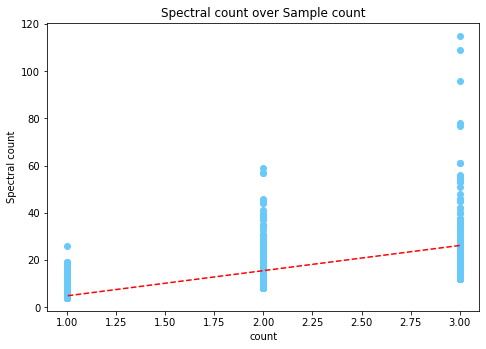

[10.675688   -5.88063833]
0.4772747946015098


<Figure size 432x288 with 0 Axes>

In [88]:
fig=plt.figure()
ax=fig.add_axes([0,0,1,1])
ax.scatter(df['count'], df['Spectral count'], color='#69cafa')
z = np.polyfit(df['count'], df['Spectral count'], 1)
p = np.poly1d(z)
plt.plot(df['count'],p(df['count']),"r--")
ax.set_xlabel('count')
ax.set_ylabel('Spectral count')
ax.set_title('Spectral count over Sample count')
plt.show()
correlation_matrix = np.corrcoef(df['count'], df['Spectral count'])
correlation_xy = correlation_matrix[0,1]
r_squared = correlation_xy**2
print(z)
print(r_squared)

In [14]:
df.sort_values(['Spectral count'], ascending=False)

,Peptide,Mass,Length,RT,Spectral count,Spectral count Sample 31,Spectral count Sample 34,Spectral count Sample 39,count,N-cut,C-cut,First aa,Last aa
Accession,,,,,,,,,,,,,
sp|P68871|HBB_HUMAN:sp|P02042|HBD_HUMAN,AGVANALAHKYH,1251.1440,12.0,86.333333,115,40.0,15.0,60.0,3,AGVA,HKYH,A,H
sp|P68871|HBB_HUMAN:sp|P02042|HBD_HUMAN,GVANALAHKYH,1179.9429,11.0,75.975000,109,42.0,12.0,55.0,3,GVAN,HKYH,G,H
sp|P68871|HBB_HUMAN:sp|P02042|HBD_HUMAN,ANALAHKYH,1023.8530,9.0,59.131667,96,35.0,9.0,52.0,3,ANAL,HKYH,A,H
sp|P68871|HBB_HUMAN,VHLTPEEKSAV,1208.6400,11.0,50.666667,78,28.0,14.0,36.0,3,VHLT,KSAV,V,V
sp|P69905|HBA_HUMAN,STVLTSKYR,1053.5818,9.0,119.810000,77,21.0,15.0,41.0,3,STVL,SKYR,S,R
...,...,...,...,...,...,...,...,...,...,...,...,...,...
sp|P05204|HMGN2_HUMAN,PKPEPKPK,919.5491,8.0,26.760000,4,0.0,0.0,4.0,1,PKPE,PKPK,P,K
sp|P05204|HMGN2_HUMAN,KPAPPKPEPKPK,1312.7866,12.0,19.090000,4,4.0,0.0,0.0,1,KPAP,PKPK,K,K
sp|P05204|HMGN2_HUMAN,KGKADAGKEGNNPAENGDAK,1971.4213,20.0,17.715000,4,0.0,0.0,4.0,1,KGKA,GDAK,K,K


In [28]:
#Here we sort on the C and N-cut

df_N=df.groupby(['Accession', 'N-cut']).sum()
df_N=df_N.sort_values(['count'], ascending=False)
df_N=df_N.drop(['Mass','Length','RT'], axis=1)
#sorted by accession and then C-cut. KGEE is found 48 times in APOC2
df_C=df.groupby(['Accession', 'C-cut']).sum()
df_C=df_C.drop(['Mass','Length','RT'], axis=1)
df_C=df_C.sort_values(['Spectral count'], ascending=False)

df_N.head()


Spectral count  Spectral count Sample 31  \
Accession           N-cut                                             
sp|P69905|HBA_HUMAN VLSP              426                     163.0   
                    TYFP              300                     142.0   
                    FDLS              230                      64.0   
sp|P68871|HBB_HUMAN VHLT              301                     115.0   
sp|P69905|HBA_HUMAN VGAH              220                      66.0   

                           Spectral count Sample 34  Spectral count Sample 39  \
Accession           N-cut                                                       
sp|P69905|HBA_HUMAN VLSP                       48.0                     215.0   
                    TYFP                        5.0                     153.0   
                    FDLS                       35.0                     131.0   
sp|P68871|HBB_HUMAN VHLT                       32.0                     154.0   
sp|P69905|HBA_HUMAN VGAH                       33.0                     120.0   

                           count  
Accession           N-cut         
sp|P69905|HBA_HUMAN VLSP      43  
                    TYFP      39  
                    FDLS      33  
sp|P68871|HBB_HUMAN VHLT      31  
sp|P69905|HBA_HUMAN VGAH      27

607
582


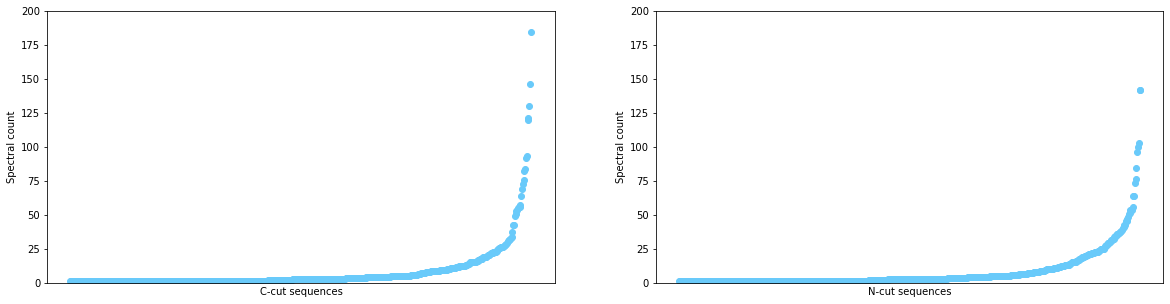

In [16]:
#These graphs show how the variation of N/C-GROUPS vary in a sample. As seen, it's not linear but exponential.

df_N.reset_index(['Accession'], inplace=True)
df_C.reset_index(['Accession'], inplace=True)
df_C=df.groupby(['C-cut']).sum()
df_N=df.groupby(['N-cut']).sum()
df_N=df_N.sort_values('Spectral count')
df_C=df_C.sort_values('Spectral count')
fig, ax = plt.subplots(1,2,figsize=(20,5))
plt.setp(ax, ylim=(0,200))
ax[1].set_xticklabels([])
ax[0].set_xticklabels([])
ax[0].set_xlabel('C-cut sequences')
ax[1].set_xlabel('N-cut sequences')
ax[0].set_ylabel('Spectral count')
ax[1].set_ylabel('Spectral count')
ax[1].scatter(df_N.index, df_N['Spectral count']/number_of_files, color='#69cafa') #row=0, col=0, kanske mer relevant att kolla mot feature? Annars tittar vi mot "variation"
ax[0].scatter(df_C.index, df_C['Spectral count']/number_of_files, color='#69cafa') #row=1, col=0
ax[0].tick_params(
    axis='x',          
    which='both',      
    bottom=False,      
    top=False,         
    labelbottom=False)
ax[1].tick_params(
    axis='x',          
    which='both',      
    bottom=False,      
    top=False,         
    labelbottom=False)
print(len(df_N.index))
print(len(df_C.index))

In [17]:
#This adds the N/C-grouped column when df is grouped mainly on protein, although the index is removed, and then on N/C-cutsite which is kept. 
#It is therefore still indirectly sorted on protein. There is no "respective peptide" available, although this can be easily added by sorting on Peptide aswell.

#might be an easier way to code

df_N= df.groupby(['Accession','N-cut']).sum() #groups original DataFrame by protein and n-cut. Makes protein and cut indexes
df_N = df_N.sort_values(['count','Spectral count'], ascending=False) #sorts these values by count and feature
df_N.reset_index(['Accession'], inplace=True) #removes protein from index, only cut left
df_N['N-grouped']=group(df_N.index) #creates column of N-grouped based on index, cut
df_N=df_N.drop(['Mass', 'Length','RT'], axis=1)
df_N=df_N.groupby(['N-grouped']).sum() #groups by N-grouped instead

df_N=df_N.sort_values(['count','Spectral count'], ascending=False) #sorts the grouped index on count and feature

df_C = df.groupby(['Accession','C-cut']).sum() 
df_C = df_C.sort_values(['count','Spectral count'], ascending=False)
df_C.reset_index(['Accession'], inplace=True)
df_C['C-grouped']=group(df_C.index)
df_C=df_C.drop(['Mass', 'Length','RT'], axis=1)
df_C=df_C.groupby(['C-grouped']).sum()

df_C=df_C.sort_values(['count','Spectral count'], ascending=False)
df_C.head()

,Spectral count,Spectral count Sample 31,Spectral count Sample 34,Spectral count Sample 39,count
C-grouped,,,,,
NPNN,1334,570.0,83.0,680.0,162
NNNB,593,236.0,63.0,294.0,108
BNNN,676,294.0,44.0,337.0,96
NNBN,515,229.0,29.0,257.0,89
NBNB,606,286.0,41.0,279.0,75


159
147


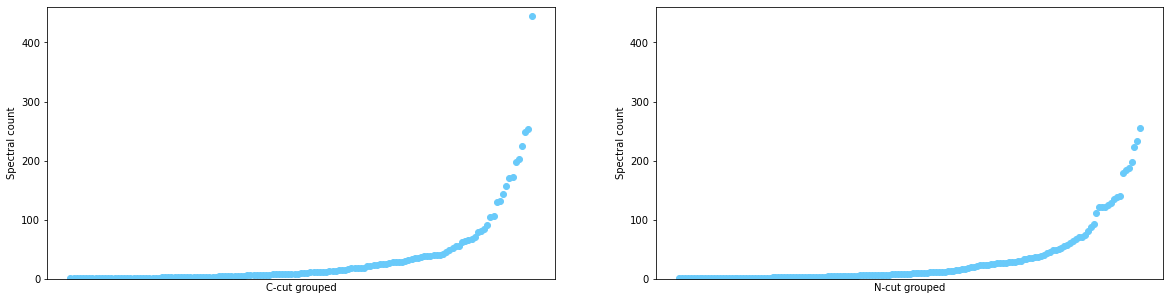

In [18]:
#These graphs show how the variation of N/C-GROUPS vary in a sample. As seen, it's not linear but exponential.
#These graphs show how the variation of N/C-GROUPS vary in a sample. As seen, it's not linear but exponential.
df_N=df_N.sort_values(['Spectral count'], ascending=True)
df_C=df_C.sort_values(['Spectral count'], ascending=True)
fig, ax = plt.subplots(1,2, figsize=(20,5))
plt.setp(ax, ylim=(0,460))
ax[1].set_xticklabels([])
ax[0].set_xticklabels([])
ax[0].set_xlabel('C-cut grouped')
ax[1].set_xlabel('N-cut grouped')
ax[0].set_ylabel('Spectral count')
ax[1].set_ylabel('Spectral count')
ax[1].scatter(df_N.index, df_N['Spectral count']/number_of_files, color='#69cafa') #row=0, col=0
ax[0].scatter(df_C.index, df_C['Spectral count']/number_of_files, color='#69cafa') #row=1, col=0
ax[0].tick_params(
    axis='x',          
    which='both',      
    bottom=False,      
    top=False,         
    labelbottom=False)
ax[1].tick_params(
    axis='x',          
    which='both',      
    bottom=False,      
    top=False,         
    labelbottom=False)
print(len(df_N.index))
print(len(df_C.index))

# Non-infected samples start here

In [19]:
mapp='peptide_sample_ninf'
files = os.listdir(mapp)
# gets all xlsx files in cwd
files_xlsx = [f for f in files if f[-4:] == 'xlsx']
df = pd.DataFrame()
for_stdev=[]
total_number_of_peptides=0
number_of_files=0
for file in files_xlsx:
    number_of_files+=1
    data = pd.read_excel(mapp+ '/' +file, 'peptide')
    total_number_of_peptides+=len(data.index)
    print("Number of total (including modified) peptides in "+file+" "+str(len(data.index)))
    for_stdev.append(len(data.index))
    data['Peptide']=data['Peptide'].str.replace('[^a-zA-Z]','')
    data['count']=1
    data = data.groupby(['Peptide','Accession'], as_index=False).sum()
    data['Mass']=data['Mass']/data['count']
    data['Length']=data['Length']/data['count']
    data['RT']=data['RT']/data['count']
    print("Number of un-modified peptides in "+file+" "+str(len(data.index)))
    data = data.loc[(data['#Feature'] >= 4)] # sorts out if feature<4
    df = df.append(data)  # appends all data


df['count'] = 1
df = df.groupby(['Accession','Peptide']).sum()
df.reset_index(['Peptide'], inplace=True)
df['N-cut']=df['Peptide'].apply(lambda x: x[0:4]) #this can be changed to view different amounts of AA
df['C-cut']=df['Peptide'].apply(lambda x: x[-4::1])
df['First aa']=df['Peptide'].apply(lambda x: x[0:1])
df['Last aa']=df['Peptide'].apply(lambda x: x[-1::1])
df['Spectral count']=df['#Feature']
df['Spectral count Sample 13']=df['#Feature Sample 13']
df['Spectral count Sample 21']=df['#Feature Sample 21']
df['Spectral count Sample 33']=df['#Feature Sample 33']
df = df[['Peptide', 'Mass', 'Length', 'RT', 'Spectral count', 'Spectral count Sample 13','Spectral count Sample 21', 'Spectral count Sample 33','count', 'N-cut', 'C-cut','First aa','Last aa']]
df['Mass']=df['Mass']/df['count']
df['Length']=df['Length']/df['count']
df['RT']=df['RT']/df['count']
df = df.sort_values(['count','Spectral count'], ascending=False)

aminoacids= get_letter_frequency(df['Peptide']*df['count'])
N_aminoacids=get_letter_frequency(df['N-cut']*df['count'])
C_aminoacids=get_letter_frequency(df['C-cut']*df['count'])
First_aa=get_letter_frequency(df['First aa']*df['count'])
Last_aa=get_letter_frequency(df['Last aa']*df['count'])


print("Standard deviation: "+ str(np.std(for_stdev)))
print("Total amount of peptides "+str(total_number_of_peptides))
print("Average length: "+str(df['Length'].mean()))
print("Average mass: "+str(df['Mass'].mean()))
print("Total number of peptides with feature>=4: "+str(len(df.index)))
print("Number of peptides with feature>=4: "+str(len(df.index))+", in percent: "+str(100*(len(df.index))/(total_number_of_peptides))+" %")
df.head()


Number of total (including modified) peptides in peptide_sample_13.xlsx 3146
Number of un-modified peptides in peptide_sample_13.xlsx 2638
Number of total (including modified) peptides in peptide_sample_21.xlsx 4863
Number of un-modified peptides in peptide_sample_21.xlsx 4076
Number of total (including modified) peptides in peptide_sample_33.xlsx 4277
Number of un-modified peptides in peptide_sample_33.xlsx 3476
Standard deviation: 712.6356401103972
Total amount of peptides 12286
Average length: 12.375892857142857
Average mass: 1352.1624395512686
Total number of peptides with feature>=4: 1120
Number of peptides with feature>=4: 1120, in percent: 9.116067068207716 %


,Peptide,Mass,Length,RT,Spectral count,Spectral count Sample 13,Spectral count Sample 21,Spectral count Sample 33,count,N-cut,C-cut,First aa,Last aa
Accession,,,,,,,,,,,,,
sp|P02671|FIBA_HUMAN,MELERPGGNEITR,1509.224925,13.0,55.168333,94,18.0,35.0,40.0,3,MELE,EITR,M,R
sp|P02671|FIBA_HUMAN,MELERPGGNEIT,1353.123825,12.0,64.688333,69,18.0,32.0,18.0,3,MELE,NEIT,M,T
sp|P68871|HBB_HUMAN:sp|P02042|HBD_HUMAN,ANALAHKYH,1023.525000,9.0,57.370000,46,8.0,12.0,26.0,3,ANAL,HKYH,A,H
sp|P68871|HBB_HUMAN:sp|P02042|HBD_HUMAN,GVANALAHKYH,1179.778900,11.0,85.286667,46,13.0,13.0,20.0,3,GVAN,HKYH,G,H
sp|P68871|HBB_HUMAN:sp|P02042|HBD_HUMAN,AGVANALAHKYH,1250.652000,12.0,96.916667,41,11.0,12.0,18.0,3,AGVA,HKYH,A,H


Text(0.5, 1.0, 'Last aminoacid')

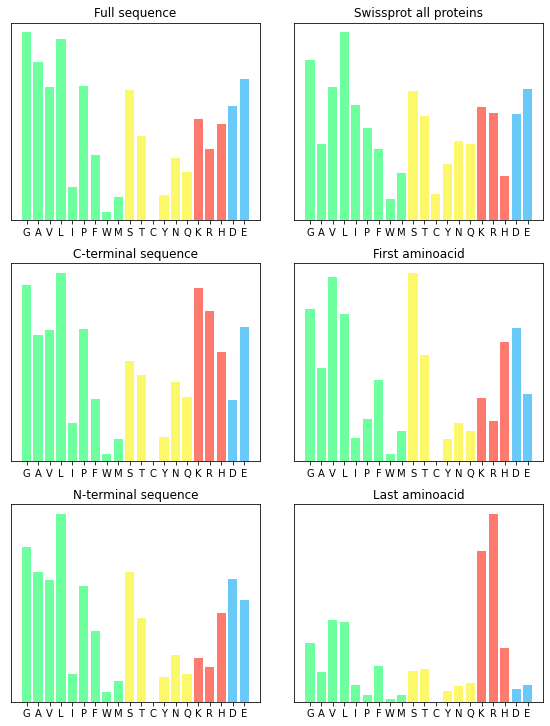

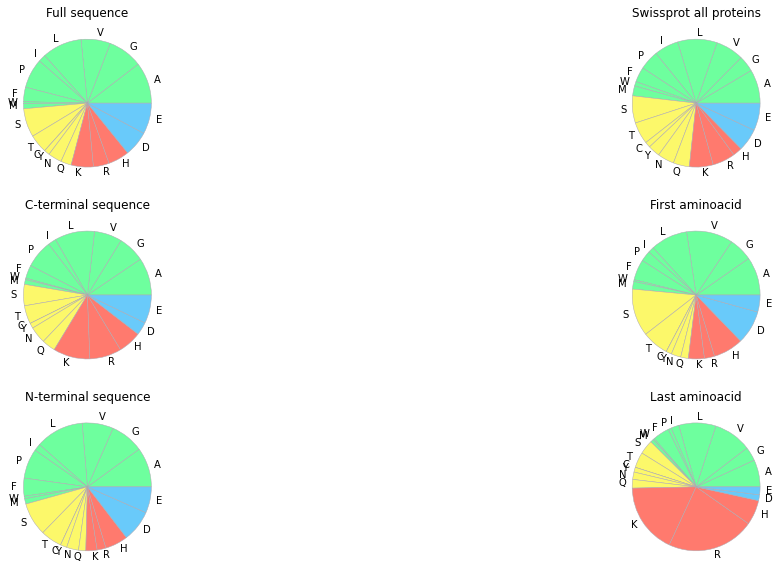

In [20]:

color=['#6eff9e', '#6eff9e','#6eff9e','#6eff9e','#6eff9e','#6eff9e','#6eff9e','#6eff9e','#6eff9e','#fcf86a','#fcf86a','#fcf86a','#fcf86a','#fcf86a','#fcf86a','#ff7a6e','#ff7a6e','#ff7a6e','#69cafa','#69cafa','#69cafa']


fig, ax1 = plt.subplots(3,2,figsize=(8,10))
ax1[0,0].bar(range(len(aminoacids)), list(aminoacids.values()), align='center', color=color)
ax1[2,0].bar(range(len(N_aminoacids)), list(N_aminoacids.values()), align='center', color=color)
ax1[1,0].bar(range(len(C_aminoacids)), list(C_aminoacids.values()), align='center', color=color)
ax1[1,1].bar(range(len(First_aa)), list(First_aa.values()), align='center', color=color)
ax1[2,1].bar(range(len(Last_aa)), list(Last_aa.values()), align='center', color=color)
ax1[0,1].bar(range(len(Normal_aminoacids)), list(Normal_aminoacids.values()), align='center', color=color)

ax1[0,0].set_title('Full sequence')
ax1[0,1].set_title('Swissprot all proteins')
ax1[2,0].set_title('N-terminal sequence')
ax1[1,0].set_title('C-terminal sequence')
ax1[1,1].set_title('First aminoacid')
ax1[2,1].set_title('Last aminoacid')

plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=1.0)
plt.setp(ax1, xticks=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19], xticklabels=['G','A','V','L','I','P','F','W','M','S','T','C','Y','N','Q','K','R','H','D','E'], yticks=([]))

fig, ax = plt.subplots(3,2,figsize=(20,10))
wp = { 'linewidth' : 0.5, 'edgecolor' : "#afabb3" } 

ax[0,0].pie(aminoacids.values(),labels = aminoacids.keys(), colors=color, wedgeprops=wp) 
ax[2,0].pie(N_aminoacids.values(),labels =N_aminoacids.keys(), colors=color, wedgeprops=wp) 
ax[1,0].pie(C_aminoacids.values(),labels = C_aminoacids.keys(), colors=color, wedgeprops=wp) 
ax[1,1].pie(First_aa.values(),labels = First_aa.keys(), colors=color, wedgeprops=wp) 
ax[2,1].pie(Last_aa.values(),labels = Last_aa.keys(), colors=color, wedgeprops=wp) 
ax[0,1].pie(Normal_aminoacids.values(),labels = Normal_aminoacids.keys(), colors=color, wedgeprops=wp) 

ax[0,0].set_title('Full sequence')
ax[0,1].set_title('Swissprot all proteins')
ax[2,0].set_title('N-terminal sequence')
ax[1,0].set_title('C-terminal sequence')
ax[1,1].set_title('First aminoacid')
ax[2,1].set_title('Last aminoacid')

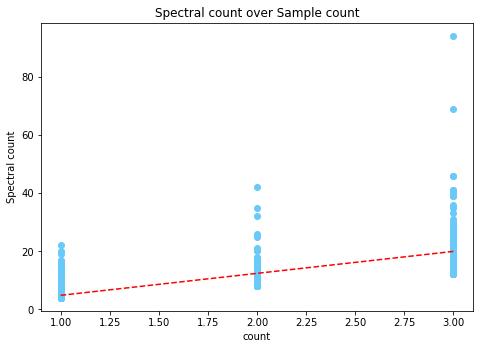

[ 7.55047414 -2.73092742]
0.5617755019462931


In [21]:
fig=plt.figure()
ax=fig.add_axes([0,0,1,1])
ax.scatter(df['count'], df['Spectral count'], color='#69cafa')
z = np.polyfit(df['count'], df['Spectral count'], 1)
p = np.poly1d(z)
plt.plot(df['count'],p(df['count']),"r--")
ax.set_xlabel('count')
ax.set_ylabel('Spectral count')
ax.set_title('Spectral count over Sample count')
plt.show()
correlation_matrix = np.corrcoef(df['count'], df['Spectral count'])
correlation_xy = correlation_matrix[0,1]
r_squared = correlation_xy**2
print(z)
print(r_squared)

In [22]:
df.sort_values(['Spectral count'], ascending=False)[0:30]

,Peptide,Mass,Length,RT,Spectral count,Spectral count Sample 13,Spectral count Sample 21,Spectral count Sample 33,count,N-cut,C-cut,First aa,Last aa
Accession,,,,,,,,,,,,,
sp|P02671|FIBA_HUMAN,MELERPGGNEITR,1509.224925,13.0,55.168333,94,18.0,35.0,40.0,3,MELE,EITR,M,R
sp|P02671|FIBA_HUMAN,MELERPGGNEIT,1353.123825,12.0,64.688333,69,18.0,32.0,18.0,3,MELE,NEIT,M,T
sp|P68871|HBB_HUMAN:sp|P02042|HBD_HUMAN,ANALAHKYH,1023.525000,9.0,57.370000,46,8.0,12.0,26.0,3,ANAL,HKYH,A,H
sp|P68871|HBB_HUMAN:sp|P02042|HBD_HUMAN,GVANALAHKYH,1179.778900,11.0,85.286667,46,13.0,13.0,20.0,3,GVAN,HKYH,G,H
sp|P69905|HBA_HUMAN,AHVDDMPNALSALSDLHAH,2021.426875,19.0,95.971250,42,23.0,19.0,0.0,2,AHVD,LHAH,A,H
sp|P68871|HBB_HUMAN:sp|P02042|HBD_HUMAN,AGVANALAHKYH,1250.652000,12.0,96.916667,41,11.0,12.0,18.0,3,AGVA,HKYH,A,H
sp|P69905|HBA_HUMAN,VGAHAGEYGAEALER,1528.726900,15.0,58.986667,41,16.0,14.0,11.0,3,VGAH,ALER,V,R
sp|P69905|HBA_HUMAN,LTNAVAHVDDMPNALSALSDLHAH,2521.340603,24.0,111.584167,40,19.0,16.0,5.0,3,LTNA,LHAH,L,H
sp|P69905|HBA_HUMAN,MFLSFPTTK,1078.544500,9.0,98.605000,40,12.0,14.0,14.0,3,MFLS,PTTK,M,K


In [23]:
#Here we sort on the C and N-cut

df_N=df.groupby(['Accession', 'N-cut']).sum()
df_N=df_N.sort_values(['count'], ascending=False)
df_N=df_N.drop(['Mass','Length','RT'], axis=1)
#sorted by accession and then C-cut. KGEE is found 48 times in APOC2
df_C=df.groupby(['Accession', 'C-cut']).sum()
df_C=df_C.drop(['Mass','Length','RT'], axis=1)
df_C=df_C.sort_values(['count'], ascending=False)

df_N.head()


Spectral count  Spectral count Sample 13  \
Accession           N-cut                                             
sp|P69905|HBA_HUMAN VLSP              134                      35.0   
                    TYFP              124                      19.0   
                    VGAH              130                      43.0   
sp|P68871|HBB_HUMAN VHLT              123                      31.0   
sp|P69905|HBA_HUMAN LTNA              145                      55.0   

                           Spectral count Sample 21  Spectral count Sample 33  \
Accession           N-cut                                                       
sp|P69905|HBA_HUMAN VLSP                       48.0                      51.0   
                    TYFP                       48.0                      57.0   
                    VGAH                       42.0                      45.0   
sp|P68871|HBB_HUMAN VHLT                       47.0                      45.0   
sp|P69905|HBA_HUMAN LTNA                       47.0                      43.0   

                           count  
Accession           N-cut         
sp|P69905|HBA_HUMAN VLSP      22  
                    TYFP      21  
                    VGAH      20  
sp|P68871|HBB_HUMAN VHLT      19  
sp|P69905|HBA_HUMAN LTNA      16

618
570


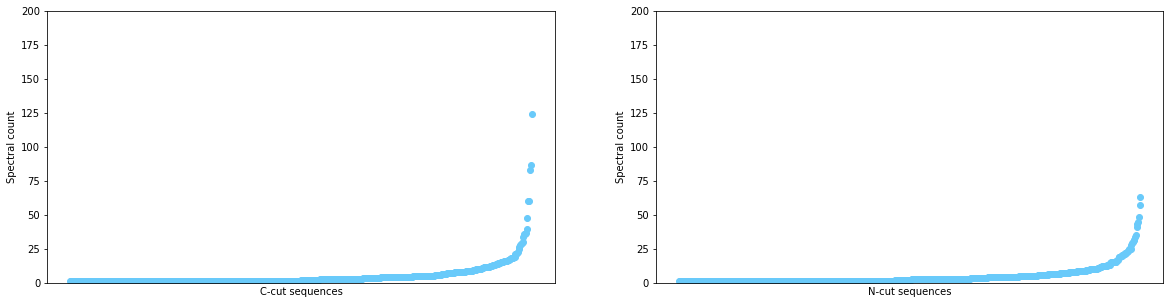

In [24]:
#These graphs show how the variation of N/C-GROUPS vary in a sample. As seen, it's not linear but exponential.

df_N.reset_index(['Accession'], inplace=True)
df_C.reset_index(['Accession'], inplace=True)
df_C=df.groupby(['C-cut']).sum()
df_N=df.groupby(['N-cut']).sum()

df_N=df_N.sort_values('Spectral count')
df_C=df_C.sort_values('Spectral count')
fig, ax = plt.subplots(1,2,figsize=(20,5))
plt.setp(ax, ylim=(0,200))
ax[1].set_xticklabels([])
ax[0].set_xticklabels([])
ax[0].set_xlabel('C-cut sequences')
ax[1].set_xlabel('N-cut sequences')
ax[0].set_ylabel('Spectral count')
ax[1].set_ylabel('Spectral count')
ax[1].scatter(df_N.index, df_N['Spectral count']/number_of_files, color='#69cafa') #row=0, col=0, kanske mer relevant att kolla mot feature? Annars tittar vi mot "variation"
ax[0].scatter(df_C.index, df_C['Spectral count']/number_of_files, color='#69cafa') #row=1, col=0
ax[0].tick_params(
    axis='x',          
    which='both',      
    bottom=False,      
    top=False,         
    labelbottom=False)
ax[1].tick_params(
    axis='x',          
    which='both',      
    bottom=False,      
    top=False,         
    labelbottom=False)
print(len(df_N.index))
print(len(df_C.index))

In [25]:
#This adds the N/C-grouped column when df is grouped mainly on protein, although the index is removed, and then on N/C-cutsite which is kept. 
#It is therefore still indirectly sorted on protein. There is no "respective peptide" available, although this can be easily added by sorting on Peptide aswell.

#might be an easier way to code

df_N= df.groupby(['Accession','N-cut']).sum() #groups original DataFrame by protein and n-cut. Makes protein and cut indexes
df_N = df_N.sort_values(['count','Spectral count'], ascending=False) #sorts these values by count and feature
df_N.reset_index(['Accession'], inplace=True) #removes protein from index, only cut left
df_N['N-grouped']=group(df_N.index) #creates column of N-grouped based on index, cut
df_N=df_N.drop(['Mass', 'Length','RT'], axis=1)
df_N=df_N.groupby(['N-grouped']).sum() #groups by N-grouped instead

df_N=df_N.sort_values(['count','Spectral count'], ascending=False) #sorts the grouped index on count and feature

df_C = df.groupby(['Accession','C-cut']).sum() 
df_C = df_C.sort_values(['count','Spectral count'], ascending=False)
df_C.reset_index(['Accession'], inplace=True)
df_C['C-grouped']=group(df_C.index)
df_C=df_C.drop(['Mass', 'Length','RT'], axis=1)
df_C=df_C.groupby(['C-grouped']).sum()


df_C=df_C.sort_values(['Spectral count'], ascending=False)
df_C.head()

,Spectral count,Spectral count Sample 13,Spectral count Sample 21,Spectral count Sample 33,count
C-grouped,,,,,
NBNB,604,207.0,273.0,122.0,76
NNNB,512,132.0,165.0,215.0,106
NNPN,449,102.0,138.0,209.0,66
NNAB,303,84.0,94.0,125.0,53
NPNB,288,70.0,118.0,100.0,53


153
163


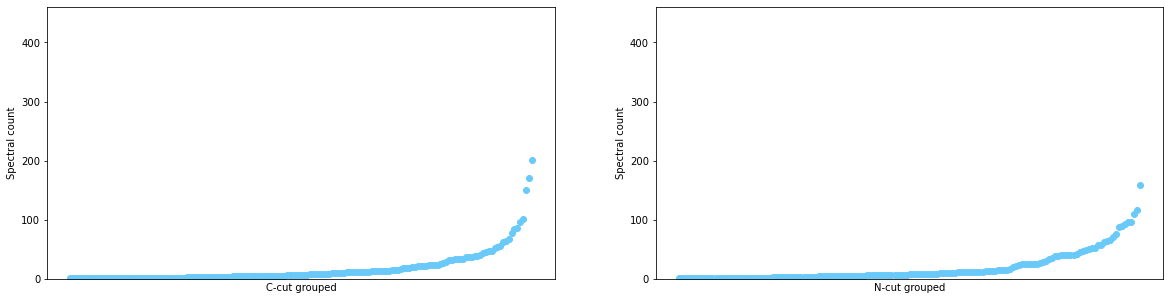

In [26]:
#These graphs show how the variation of N/C-GROUPS vary in a sample. As seen, it's not linear but exponential.
#These graphs show how the variation of N/C-GROUPS vary in a sample. As seen, it's not linear but exponential.
df_N=df_N.sort_values(['Spectral count'], ascending=True)
df_C=df_C.sort_values(['Spectral count'], ascending=True)
fig, ax = plt.subplots(1,2, figsize=(20,5))
plt.setp(ax, ylim=(0,460))
ax[1].set_xticklabels([])
ax[0].set_xticklabels([])
ax[0].set_xlabel('C-cut grouped')
ax[1].set_xlabel('N-cut grouped')
ax[0].set_ylabel('Spectral count')
ax[1].set_ylabel('Spectral count')
ax[1].scatter(df_N.index, df_N['Spectral count']/number_of_files, color='#69cafa') #row=0, col=0
ax[0].scatter(df_C.index, df_C['Spectral count']/number_of_files, color='#69cafa') #row=1, col=0
ax[0].tick_params(
    axis='x',          
    which='both',      
    bottom=False,      
    top=False,         
    labelbottom=False)
ax[1].tick_params(
    axis='x',          
    which='both',      
    bottom=False,      
    top=False,         
    labelbottom=False)
print(len(df_N.index))
print(len(df_C.index))